In [1]:
from tqdm import tqdm
import numpy as np
import cv2
import os
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import *
from tensorflow.keras.applications.efficientnet import *
from tensorflow.keras.applications.vgg16 import *
import warnings

In [2]:
warnings.filterwarnings('ignore')
plt.rcParams["figure.dpi"] = 120
image_dimension = (224, 224)
epochs=60
batch_size = 32

#### Check whether GPU is available

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Load Data, Label for prediction (currently use one dataset (Brain MRI Data2))

In [4]:
labels = {"glioma_tumor":1, "meningioma_tumor":2, "no_tumor":0, "pituitary_tumor":3}
dir_name = "MRI_DATA"
image_list = list()
truth_list = list()

for label, index in labels.items():
    path = os.path.join("Brain_MRI_data2", dir_name, label)
    images = os.listdir(path)
    for image in tqdm(images):
        current_image = cv2.imread(os.path.join(path, image))
        current_image = cv2.resize(current_image, image_dimension)
        image_list.append(current_image)
        truth_list.append(index)

features = np.array(image_list)/255.0 # rescale
labels = tf.keras.utils.to_categorical(truth_list)

100%|██████████| 2658/2658 [00:09<00:00, 269.75it/s]


In [5]:
print("image dimension: {}, label dimension: {}".format(features.shape, labels.shape))

image dimension: (10287, 224, 224, 3), label dimension: (10287, 4)


#### Split dataset into train, validation and test set

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, shuffle=True)
train_generator = ImageDataGenerator(validation_split=0.25)
test_generator = ImageDataGenerator()

train_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="training")
validation_df = train_generator.flow(X_train, y_train, batch_size=batch_size, subset="validation")
test_df = train_generator.flow(X_test, y_test, batch_size=batch_size)

#### Use a simple CNN for training

In [62]:
model_simple_cnn = models.Sequential()
model_simple_cnn.add(layers.Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)))
model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple_cnn.add(layers.Conv2D(32, 3, activation='relu'))
model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple_cnn.add(layers.Conv2D(64, 3, activation='relu'))
model_simple_cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))
model_simple_cnn.add(layers.Flatten())
model_simple_cnn.add(layers.Dense(256, activation='softmax'))
model_simple_cnn.add(layers.Dropout(0.5))
model_simple_cnn.add(layers.Dense(4, activation='softmax'))
model_simple_cnn.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_simple_cnn.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 26, 26, 64)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 43264)            

In [63]:
history_simple_cnn_history = model_simple_cnn.fit(train_df,
                                                  epochs=epochs,
                                                  verbose=1,
                                                  validation_data=validation_df)

Epoch 1/100
181/181 [==============================] - 5s 24ms/step - loss: 1.3373 - accuracy: 0.3402 - val_loss: 1.3225 - val_accuracy: 0.4118
Epoch 2/100
181/181 [==============================] - 4s 23ms/step - loss: 1.3426 - accuracy: 0.3214 - val_loss: 1.3081 - val_accuracy: 0.4212
Epoch 3/100
181/181 [==============================] - 4s 24ms/step - loss: 1.3096 - accuracy: 0.3522 - val_loss: 1.2928 - val_accuracy: 0.4165
Epoch 4/100
181/181 [==============================] - 4s 23ms/step - loss: 1.2877 - accuracy: 0.3449 - val_loss: 1.2398 - val_accuracy: 0.4455
Epoch 5/100
181/181 [==============================] - 4s 23ms/step - loss: 1.2636 - accuracy: 0.3461 - val_loss: 1.2022 - val_accuracy: 0.4533
Epoch 6/100
181/181 [==============================] - 4s 23ms/step - loss: 1.2552 - accuracy: 0.3437 - val_loss: 1.2384 - val_accuracy: 0.4139
Epoch 7/100
181/181 [==============================] - 4s 23ms/step - loss: 1.2254 - accuracy: 0.3615 - val_loss: 1.1614 - val_accuracy:

Text(0.5, 1.0, 'Simple CNN Model')

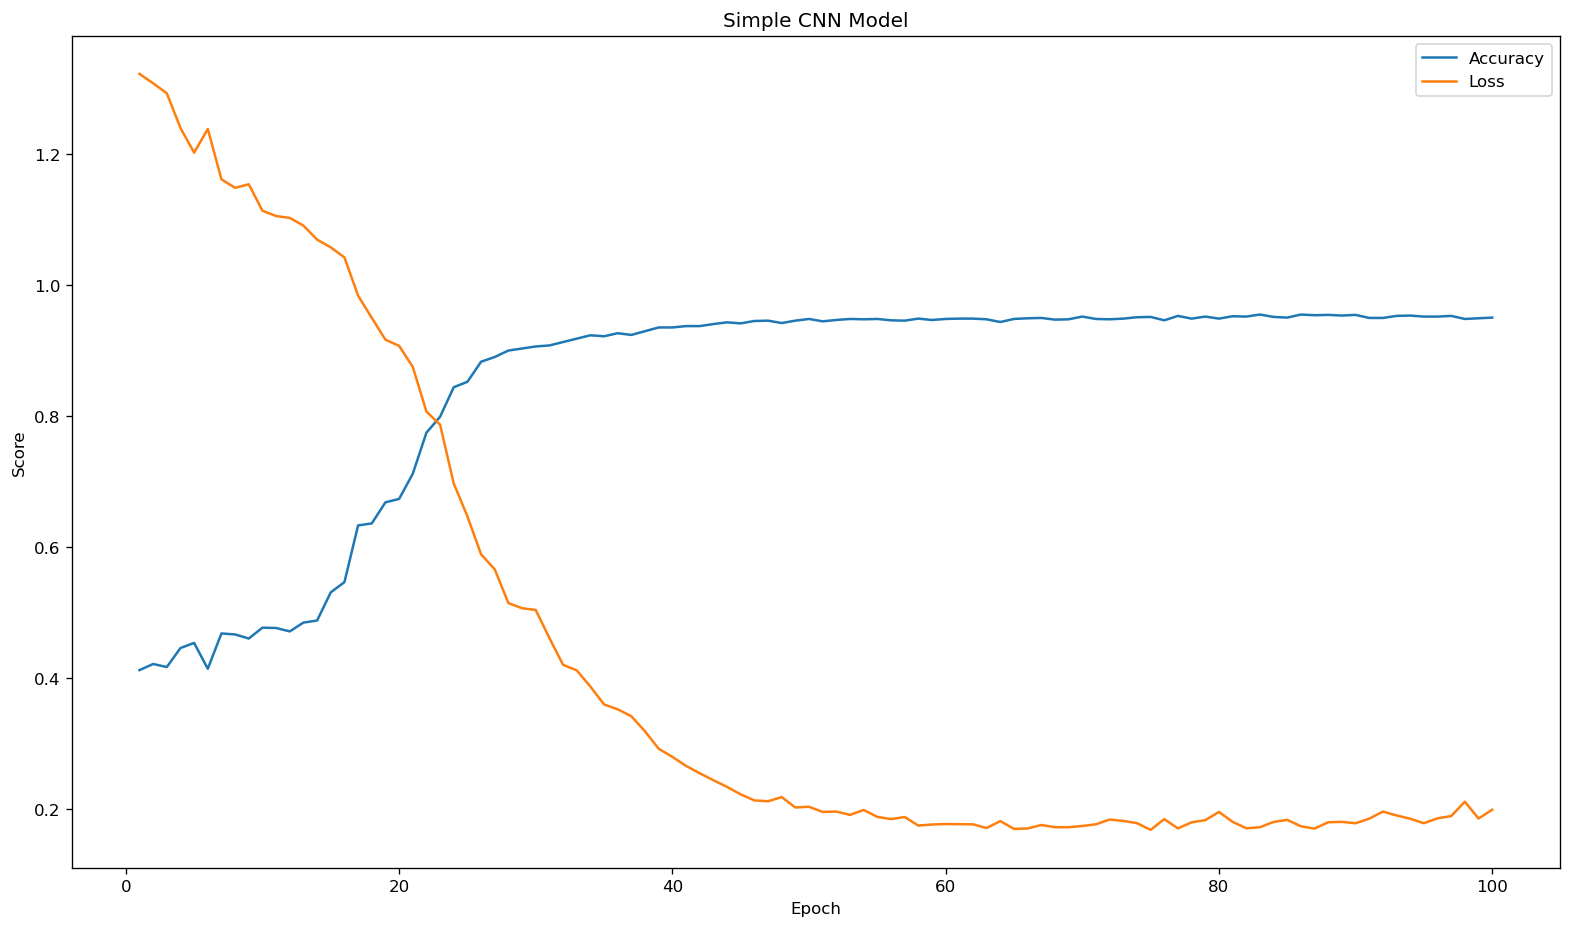

In [70]:
epoch_index = [i for i in range(1, epochs+1)]
simple_cnn_result = pd.DataFrame({"Accuracy": history_simple_cnn_history.history["val_accuracy"],
                                  "Loss": history_simple_cnn_history.history["val_loss"]}, index=epoch_index)
ax_simple_cnn = simple_cnn_result.plot.line(figsize=(16, 9))
ax_simple_cnn.set_xlabel("Epoch")
ax_simple_cnn.set_ylabel("Score")
ax_simple_cnn.set_title("Simple CNN Model")

#### Using Resnet50 for training

In [71]:
base_resnet50 = ResNet50()
model_resnet = models.Sequential()
model_resnet.add(base_resnet50)
model_resnet.add(layers.Input(shape=(224, 224, 3)))
model_resnet.add(layers.Flatten())
model_resnet.add(layers.Dense(256, activation='softmax'))
model_resnet.add(layers.Dropout(0.5))
model_resnet.add(layers.Dense(4, activation='softmax'))
model_resnet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model_resnet.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1000)              25636712  
_________________________________________________________________
flatten_8 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               256256    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 1028      
Total params: 25,893,996
Trainable params: 25,840,876
Non-trainable params: 53,120
_________________________________________________________________


In [72]:
model_resnet.fit(train_df,
                 epochs=epochs,
                 verbose=1,
                 validation_data=validation_df)

Epoch 1/100
181/181 [==============================] - 27s 120ms/step - loss: 1.3837 - accuracy: 0.2639 - val_loss: 1.3863 - val_accuracy: 0.2495
Epoch 2/100
181/181 [==============================] - 19s 106ms/step - loss: 1.3755 - accuracy: 0.3624 - val_loss: 1.3880 - val_accuracy: 0.2324
Epoch 3/100
181/181 [==============================] - 19s 105ms/step - loss: 1.3494 - accuracy: 0.4947 - val_loss: 1.3905 - val_accuracy: 0.2500
Epoch 4/100
181/181 [==============================] - 19s 105ms/step - loss: 1.2951 - accuracy: 0.5925 - val_loss: 1.4025 - val_accuracy: 0.2500
Epoch 5/100
181/181 [==============================] - 19s 106ms/step - loss: 1.2437 - accuracy: 0.5575 - val_loss: 1.4652 - val_accuracy: 0.1623
Epoch 6/100
181/181 [==============================] - 19s 106ms/step - loss: 1.1825 - accuracy: 0.5644 - val_loss: 1.2782 - val_accuracy: 0.4512
Epoch 7/100
181/181 [==============================] - 19s 106ms/step - loss: 1.0900 - accuracy: 0.6026 - val_loss: 1.0469 -

<AxesSubplot:>

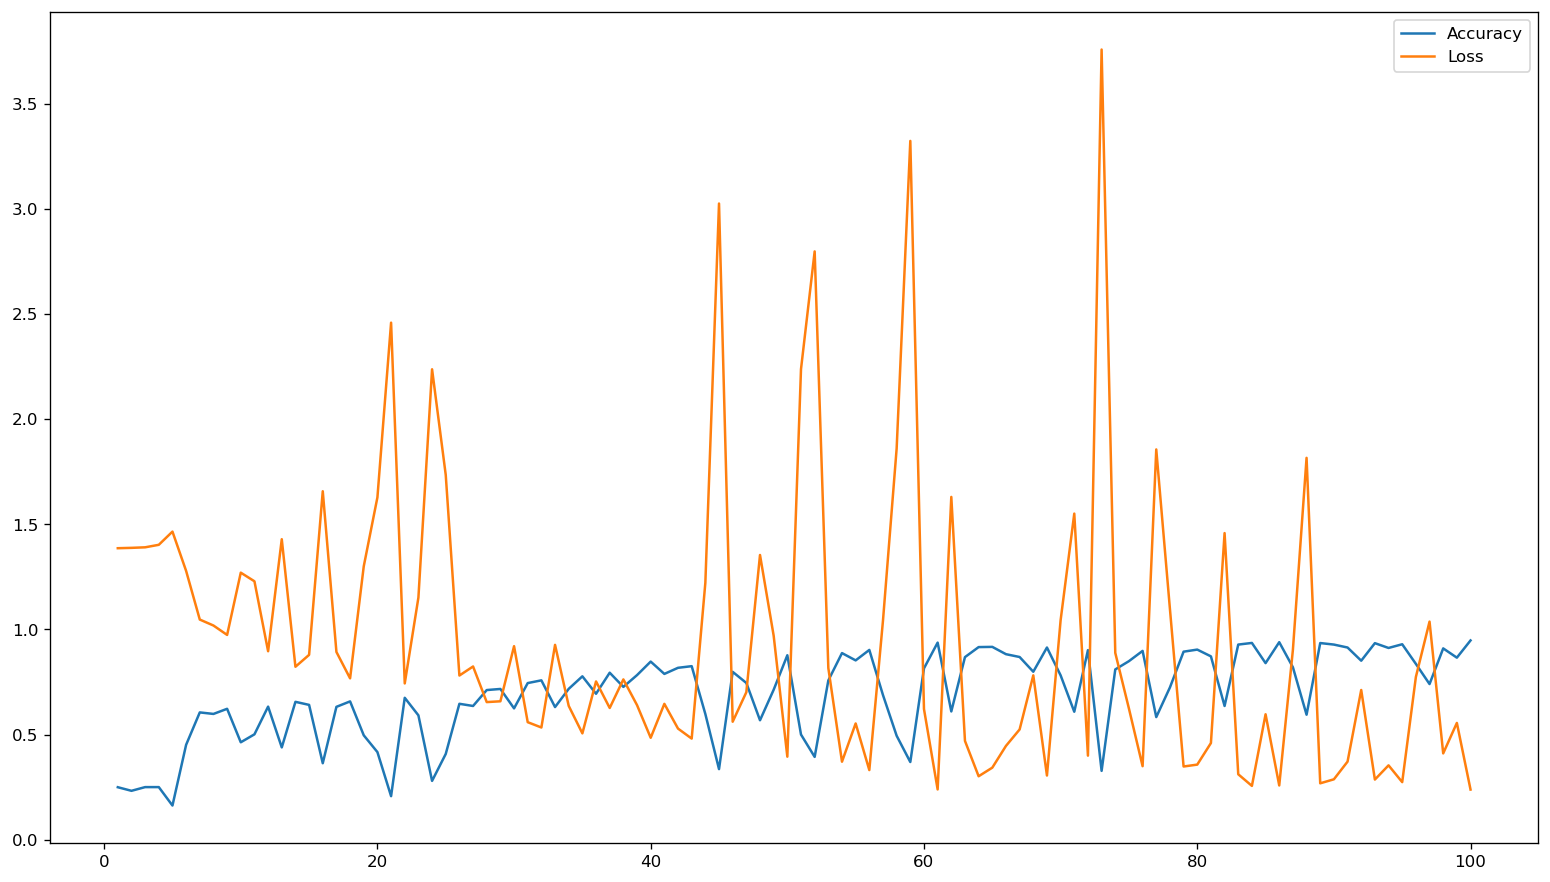

In [73]:
epoch_index = [i for i in range(1, epochs+1)]
resnet_result = pd.DataFrame({"Accuracy": model_resnet.history.history["val_accuracy"],
                                  "Loss": model_resnet.history.history["val_loss"]}, index=epoch_index)
resnet_result.plot.line(figsize=(16, 9))


#### Using VGG-16

In [15]:
base_vgg16 = VGG16(input_shape=(224, 224, 3))
model_vgg16 = models.Sequential()
model_vgg16.add(base_vgg16)
model_vgg16.add(layers.Flatten())
model_vgg16.add(layers.Dense(128, activation='relu'))
model_vgg16.add(layers.Dropout(0.5))
model_vgg16.add(layers.Dense(4, activation='softmax'))
model_vgg16.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])
model_vgg16.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 1000)              138357544 
_________________________________________________________________
flatten_2 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               128128    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 516       
Total params: 138,486,188
Trainable params: 138,486,188
Non-trainable params: 0
_________________________________________________________________


In [16]:
model_vgg16_history = model_vgg16.fit(train_df,
                                      verbose=1,
                                      epochs=epochs,
                                      validation_data=validation_df)

Epoch 1/100
181/181 [==============================] - 24s 125ms/step - loss: 1.3630 - accuracy: 0.4260 - val_loss: 1.3493 - val_accuracy: 0.7277
Epoch 2/100
181/181 [==============================] - 23s 126ms/step - loss: 1.3453 - accuracy: 0.5262 - val_loss: 1.3377 - val_accuracy: 0.7173
Epoch 3/100
181/181 [==============================] - 23s 126ms/step - loss: 1.3280 - accuracy: 0.6171 - val_loss: 1.3230 - val_accuracy: 0.7184
Epoch 4/100
181/181 [==============================] - 23s 127ms/step - loss: 1.3131 - accuracy: 0.6933 - val_loss: 1.3077 - val_accuracy: 0.8169
Epoch 5/100
181/181 [==============================] - 23s 127ms/step - loss: 1.2964 - accuracy: 0.7769 - val_loss: 1.2883 - val_accuracy: 0.8672
Epoch 6/100
181/181 [==============================] - 23s 127ms/step - loss: 1.2759 - accuracy: 0.8339 - val_loss: 1.2718 - val_accuracy: 0.8952
Epoch 7/100
181/181 [==============================] - 23s 127ms/step - loss: 1.2583 - accuracy: 0.8744 - val_loss: 1.2494 -

KeyboardInterrupt: 

In [17]:
vgg16_result = pd.DataFrame({"Accuracy": model_vgg16_history.history.history["val_accuracy"],
                             "Loss": model_vgg16_history.history.history["val_loss"]}, index=epoch_index)
vgg16_result.plot.line(figsize=(16, 9))


NameError: name 'model_vgg16_history' is not defined